# Summary

* Name: `dissipation-theory--Study-2.ipynb`
* Author: John A. Marohn
* Date: 2023-09-12
* Continued from: `dissipation-theory--Study-1.ipynb`
* Continued to: ---
* Summary: Explore Lekkala and Loring's theory for friction over a semiconductor backed by a metal.

# Preliminaries

In [107]:
import numpy as np
from dissipationtheory.constants import ureg, epsilon0, qe, kb
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import tqdm

In [2]:
THIS = 'dissipation-theory--Study-2'

# Parameters

## Sample parameters

In [3]:
sample = {
    'epsilon': ureg.Quantity(complex(50., 10.), ''), # dielectric constant at the cantilever frequency
    'rho': ureg.Quantity(1.0e18, '1/m^3'),           # charge density
    'mobility': ureg.Quantity(100., 'm^2/(V s)'),    # carrier mobility
    'thickness': ureg.Quantity(160., 'nm'),          # sample thickness
    'zr': ureg.Quantity(160., 'nm')                  # reference thickness
}

Compute the diffusion constant from the mobility.

In [4]:
sample['D'] = ((kb * ureg.Quantity(300., 'K') * sample['mobility']) / qe).to('m^2/s')
sample['D']

2.5851999850977734 <Unit('meter ** 2 / second')>

## Cantilever parameters

In [5]:
cantilever = {
    'omega_c': 2*np.pi*ureg.Quantity(8000, '1/s'), # frequency, 2*pi*8000/s = 50 kHz
    'Vts': ureg.Quantity(3.0, 'V'),                # voltage
    'height': ureg.Quantity(50., 'nm')             # cantilever height
}

# Explore the parameters

First compute the square root of the dielectric constant manually.

In [6]:
np.sqrt(complex(50., 10.))

(7.105990259489801+0.7036316990897469j)

Note compute $\sqrt{\epsilon_{\mathrm{s}}(\omega)}$ with units, to make sure we get the same answer.

In [7]:
np.sqrt(sample['epsilon']).magnitude

(7.105990259489801+0.7036316990897469j)

Compute the **Debye length** $\lambda_{\mathrm{D}}$:

In [8]:
sample['LD'] = (np.sqrt(
    (epsilon0 * kb * ureg.Quantity(300., 'K'))/
    (sample['rho'] * qe * qe))).to('nm')

sample['LD']

1195.2706101031097 <Unit('nanometer')>

Compute the **diffusion length** $\lambda_{\mathrm{d}}$:

In [9]:
sample['Ld'] = (np.sqrt(sample['D'] / cantilever['omega_c'])).to('nm')
sample['Ld']

7171535.370035875 <Unit('nanometer')>

Compute the **effective dielectric constant**:

In [10]:
sample['epsilon eff'] = (sample['epsilon'] \
  - complex(0,1) * np.power(sample['Ld'], 2.) / np.power(sample['LD'], 2.)
  ).to_base_units()

sample['epsilon eff']

(50-35999103.60618866j) <Unit('dimensionless')>

The dielectric constant $\epsilon_{\mathrm{eff}}(\omega)$ is dominated by the conductivity-related imaginary part.

# Build up the integral, try 1

A handy function for plotting the real and imaginary parts of a complex function.

In [11]:
def plotme(fcn, sample, ylabel, kind=plt.semilogx):
    
    omega_ = np.logspace(start=-3, stop=1, num=100)
    
    plt.figure(figsize=(3.25, 2.5))
    kind(omega_, np.real(fcn(omega_, sample)), label='real')
    kind(omega_, np.imag(fcn(omega_, sample)), label='imag')
    plt.xlabel('$\Omega$')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

The unitless factor $\lambda$:

In [12]:
def lambduh(omega, sample):

    r1 = sample['Ld']**2 / (sample['epsilon'] * sample['LD']**2)
    r2 = sample['zr']**2 / (sample['epsilon'] * sample['LD']**2)
    r3 = sample['zr']**2 / sample['Ld']**2
    lambduh = complex(0,1) * r1 * omega / np.sqrt(omega**2 + r2 + complex(0,1) * r3)
    return lambduh.magnitude

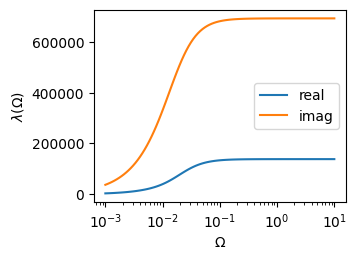

In [13]:
plotme(lambduh, sample, '$\lambda(\Omega)$')

The unitless factor $k \, h_{\mathrm{s}}$:

In [14]:
def khs(omega, samle):

    khs = omega * sample['thickness'] / sample['zr']
    return khs.magnitude

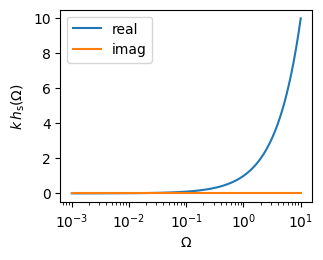

In [15]:
plotme(khs, sample, '$k \, h_{\mathrm{s}} (\Omega)$')

The unitless factor $\eta \, h_{\mathrm{s}}$:

In [16]:
def etahs(omega, sample):

    r1 = sample['thickness']**2 / sample['zr']**2
    r2 = sample['thickness']**2 / (sample['epsilon'] * sample['LD']**2)
    r3 = sample['thickness']**2 / sample['Ld']**2
    etahs = np.sqrt(r1 * omega**2 + r2 + complex(0,1) * r3)
    return etahs.magnitude

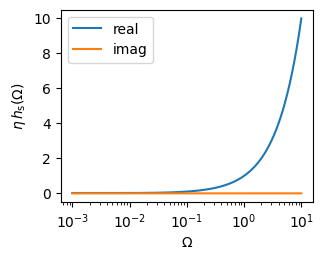

In [17]:
plotme(etahs, sample, '$\eta \, h_{\mathrm{s}} (\Omega)$')

The factor $\theta_{\mathrm{I}} \big/ \epsilon_{\mathrm{s}}$:

In [18]:
def theta1normA(omega, sample):

    lambduh_ = lambduh(omega, sample)
    khs_ = khs(omega, sample)
    etahs_ = etahs(omega, sample)
    
    r1 = 1/sample['epsilon eff']
    t1 = - lambduh_ * np.power(np.tanh(etahs_), -1.0)
    t2 = np.sinh(khs_) * np.sinh(etahs_) \
         - lambduh_ * np.cosh(khs_) * np.cosh(etahs_) \
         + 2 * lambduh_ \
         - lambduh_**2 * np.sinh(khs_) / np.sinh(etahs_)
    t3 = np.cosh(khs_) * np.sinh(etahs_) \
         - lambduh_ * np.sinh(khs_) * np.cosh(etahs_)
    
    return r1.magnitude * (t1 + t2 / t3)

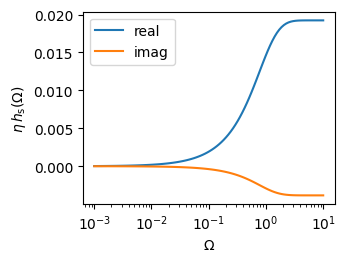

In [19]:
plotme(theta1normA, sample, '$\eta \, h_{\mathrm{s}} (\Omega)$')

Plot the $C_{\delta \phi, \delta \phi}$ integrand, with a representative argument of $z_1 / z_{\mathrm{r}} + z_2 / z_{\mathrm{r}} \rightarrow 1$ in the exponential. 

In [20]:
def integrandA(omega,sample):

    ratio = (1 - theta1normA(omega, sample)) / (1 + theta1normA(omega, sample))
    return np.exp(-omega) * np.imag(ratio)    

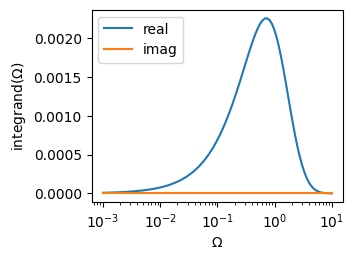

In [21]:
plotme(integrandA, sample, '$\mathrm{integrand} (\Omega)$')

Use the `integrate.quad` function from `scipy` to carry out the integral.

In [22]:
integrate.quad(integrandA, 0, np.inf, args=(sample))

/var/folders/7j/lws5z2qd2qg36wd8z0j_962wy6gl4q/T/ipykernel_1509/2972691253.py:9: RuntimeWarning: overflow encountered in scalar multiply
  t2 = np.sinh(khs_) * np.sinh(etahs_) \
/var/folders/7j/lws5z2qd2qg36wd8z0j_962wy6gl4q/T/ipykernel_1509/2972691253.py:10: RuntimeWarning: overflow encountered in scalar multiply
  - lambduh_ * np.cosh(khs_) * np.cosh(etahs_) \
/var/folders/7j/lws5z2qd2qg36wd8z0j_962wy6gl4q/T/ipykernel_1509/2972691253.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  - lambduh_ * np.cosh(khs_) * np.cosh(etahs_) \
/var/folders/7j/lws5z2qd2qg36wd8z0j_962wy6gl4q/T/ipykernel_1509/2972691253.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  t2 = np.sinh(khs_) * np.sinh(etahs_) \
/var/folders/7j/lws5z2qd2qg36wd8z0j_962wy6gl4q/T/ipykernel_1509/2972691253.py:13: RuntimeWarning: overflow encountered in scalar multiply
  t3 = np.cosh(khs_) * np.sinh(etahs_) \
/var/folders/7j/lws5z2qd2qg36wd8z0j_962wy6gl4q/T/ipykernel_1509/2972691253.py:14:

(nan, nan)

Uh oh!

# Build up the integral, try 2

With Mathematica's help, rewrite the factor $\theta_{\mathrm{I}} \big/ \epsilon_{\mathrm{s}}$ in a way that avoids overflow problems.  

First, define my own `sech(x)` and `csch(x)` functions that return 0 for large `x`, avoiding overflow problems.  See the StackOverflow discussion "Overflow in Numpy Cosh Function" ([link](https://stackoverflow.com/questions/31889801/overflow-in-numpy-cosh-function)).  I have taken extra care to define the functions so they work on both numbers and numpy arrays.  

In [23]:
def mysech(x):
    
    x = np.array(x)
    mask = abs(x) < 710.4
    values = np.zeros_like(x, dtype=complex)
    values[mask] = 1/np.cosh(x[mask])
    
    return values

Plot `mysech(x)` function alongside `1/cosh(x)` over a range of `x` where there should not be overflow problems.

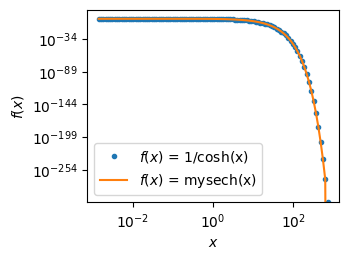

In [24]:
omega_ = np.logspace(start=-np.log10(710.4), stop=np.log10(710.4), num=100)

plt.figure(figsize=(3.25, 2.5))
plt.loglog(omega_, 1/np.cosh(omega_), '.', label='$f(x)$ = 1/cosh(x)')
plt.loglog(omega_, np.real(mysech(omega_)), '-', label='$f(x)$ = mysech(x)')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.show()

Now plot `mysech(x)` over a larger `x` range to verify that there are no overflow problems.

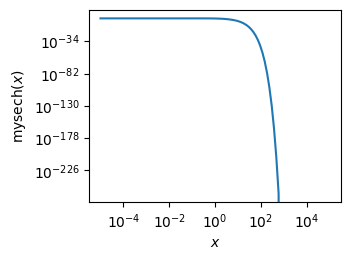

In [25]:
omega_ = np.logspace(start=-5, stop=5, num=100)

plt.figure(figsize=(3.25, 2.5))
plt.loglog(omega_, np.real(mysech(omega_)), '-')
plt.xlabel('$x$')
plt.ylabel('mysech$(x)$')
plt.show()

Define a custom `csch(x)` function analogously.

In [26]:
def mycsch(x):
    
    x = np.array(x)
    mask = abs(x) < 710.4
    values = np.zeros_like(x, dtype=complex)
    values[mask] = 1/np.sinh(x[mask])
    
    return values

We are now ready to code up a numerically stable version of the  $\theta_{\mathrm{I}} \big/ \epsilon_{\mathrm{s}}$ function.

In [27]:
def theta1normB(omega, sample):

    lambduh_ = lambduh(omega, sample)
    khs_ = khs(omega, sample)
    etahs_ = etahs(omega, sample)
    
    r1 = 1/sample['epsilon eff']
    t1 = - lambduh_ * np.power(np.tanh(etahs_), -1.0)
    t2 = np.tanh(khs_) * np.tanh(etahs_) - lambduh_ \
         + 2 * lambduh_ * mysech(khs_) * mysech(etahs_) \
         - lambduh_**2 * np.tanh(khs_) * mysech(etahs_) * mycsch(etahs_)
    t3 = np.tanh(etahs_) - lambduh_ * np.tanh(khs_)
    
    return r1.magnitude * (t1 + t2 / t3)

In [28]:
def integrandB(omega, sample):

    ratio = (1 - theta1normB(omega, sample)) / (1 + theta1normB(omega, sample))
    return np.exp(-omega) * np.imag(ratio)    

Verify, by plotting, that the new integrand and the old integrand look the same.

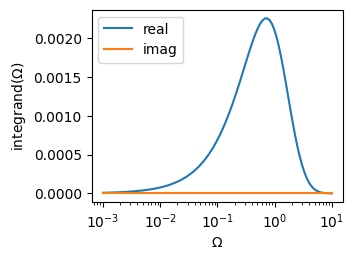

In [29]:
plotme(integrandB, sample, '$\mathrm{integrand} (\Omega)$')

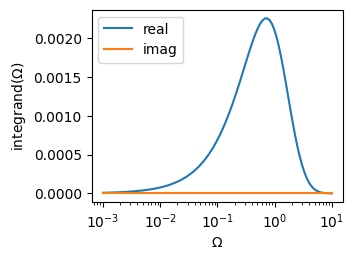

In [30]:
plotme(integrandA, sample, '$\mathrm{integrand} (\Omega)$')

The overlow problem has been solved by rewriting the function in the paper.  Python will happily integrate the newly formulated function.

In [31]:
integrate.quad(integrandB, 0, np.inf, args=(sample))

(0.0042661389899868885, 1.3646641162513393e-09)

We can get a nearly identical answer by integrating the function in the paper but giving a maximum $\Omega$ to avoid the overflow problem.  However, the integral's error is not estimated correctly.  Moreover, this is an uncontrolled approximation, since we have no idea how much error is introduced by truncating the integral.

In [32]:
integrate.quad(integrandA, 0, 1e2, args=(sample))

(0.004266138989992272, 1.8285447119200976e-13)

# Compute the main integral for more realistic parameters

In [ ]:
from dissipationtheory.capacitance import Csphere

Pick representative values for an organic sample from Lekkala's paper.

In [34]:
sample = {
    'epsilon': ureg.Quantity(complex(3.4, -0.05), ''), # dielectric constant at the cantilever frequency
    'rho': ureg.Quantity(1.0e21, '1/m^3'),            # charge density
    'mobility': ureg.Quantity(4E-7, 'm^2/(V s)'),     # carrier mobility
    'thickness': ureg.Quantity(500., 'nm'),           # sample thickness
    'zr': ureg.Quantity(500., 'nm')                   # reference thickness
}

Make a utility function to compute derived sample quantities: the diffusion constant $D$, the Debye length $L_{\mathrm{D}}$, the diffusion lenth $L_{\mathrm{d}}$, and the effective dielectric constant $\epsilon_{\mathrm{eff}}$.

In [35]:
def sample_derived_quantities(sample):
    
    sample['D'] = ((kb * ureg.Quantity(300., 'K') * sample['mobility']) / qe).to('m^2/s')
    sample['LD'] = (np.sqrt((epsilon0 * kb * ureg.Quantity(300., 'K')) / (sample['rho'] * qe * qe))).to('nm')
    sample['Ld'] = (np.sqrt(sample['D'] / cantilever['omega_c'])).to('nm')
    sample['epsilon eff'] = (sample['epsilon'] - complex(0,1) * np.power(sample['Ld'], 2.) / np.power(sample['LD'], 2.)).to_base_units()
    
    return sample

In [36]:
sample = sample_derived_quantities(sample)
sample

{'epsilon': (3.4-0.05j) <Unit('dimensionless')>,
 'rho': 1e+21 <Unit('1 / meter ** 3')>,
 'mobility': 4e-07 <Unit('meter ** 2 / second / volt')>,
 'thickness': 500.0 <Unit('nanometer')>,
 'zr': 500.0 <Unit('nanometer')>,
 'D': 1.0340799940391092e-08 <Unit('meter ** 2 / second')>,
 'LD': 37.79777548184893 <Unit('nanometer')>,
 'Ld': 453.56772179543634 <Unit('nanometer')>,
 'epsilon eff': (3.4-144.04645442475461j) <Unit('dimensionless')>}

Create a dictionary holding the cantilever properties.

In [37]:
cantilever = {
    'omega_c': 2*np.pi*ureg.Quantity(81E3, '1/s'), # frequency, 2*pi*8000/s = 50 kHz
    'Vts': ureg.Quantity(3.0, 'V'),                # voltage
    'height': ureg.Quantity(100., 'nm'),           # cantilever height
    'radius': ureg.Quantity(40., 'nm')             # cantilever radius
}

Compute and plot the tip capacitance.

/Users/jam99/Library/Caches/pypoetry/virtualenvs/dissipationtheory-Uvi85QQO-py3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


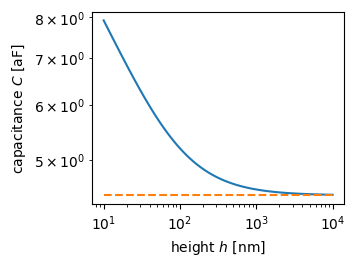

In [38]:
h_ = ureg.Quantity(np.logspace(1, 4, num=100), 'nm')
r = cantilever['radius']
Cref = (4 * np.pi * epsilon0 * r) * np.ones_like(h_)

plt.figure(figsize=(3.25, 2.5))
plt.loglog(h_, Csphere(0, h_, r).to('aF').magnitude)
plt.loglog(h_, Cref.to("aF").magnitude, '--')
plt.xlabel('height $h$ [nm]')
plt.ylabel('capacitance $C$ [aF]')
plt.show()

Compute a representative value of the capacitance first derivative, and check its units.

In [50]:
Csphere(1, h_, r)[0].to('F/m')

-1.6936391075606985e-10 <Unit('farad / meter')>

Compute a representative value of the capacitance second derivative, and check its units.

In [54]:
Csphere(2, h_, r)[0].to('F/m^2')

0.020398131940014268 <Unit('farad / meter ** 2')>

Perform the unitless integral.

In [ ]:
def integrandC(omega, sample, power):

    ratio = (1 - theta1normB(omega, sample)) / (1 + theta1normB(omega, sample))
    exponent = (2 * cantilever['height'] / sample['zr']).to('dimensionless').magnitude
    return omega**power * np.exp(-1 * omega * exponent) * np.imag(ratio) 

 Plot the integrand.  Note that it is now negative.

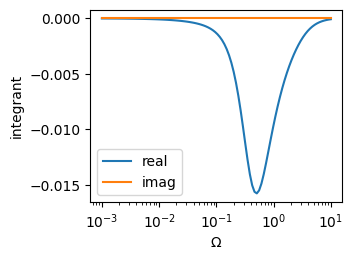

In [55]:
omega_ = np.logspace(start=-3, stop=1, num=100)

plt.figure(figsize=(3.25, 2.5))
plt.semilogx(omega_, np.real(integrandC(omega_, sample, 0)), label='real')
plt.semilogx(omega_, np.imag(integrandC(omega_, sample, 0)), label='imag')
plt.xlabel('$\Omega$')
plt.ylabel('integrant')
plt.legend()
plt.show()

Compute the integrals with different values of the exponent.

In [42]:
for power in [0, 1, 2]:
    print(integrate.quad(integrandC, 0., np.inf, args=(sample, power)))

(-0.023133120657570633, 3.116414066205001e-09)
(-0.041837487458461435, 2.3220587754577479e-10)
(-0.1617831222857996, 1.0514547417953674e-08)


Here is how we get at the value of the integrand, neglecting the error bar in the integrand.

In [43]:
integrate.quad(integrandC, 0., np.inf, args=(sample, 0.))[0]

-0.023133120657570633

Compute the integral, including the prefactors.

In [44]:
def C(power):
    pre = (-1**(power + 1) * kb * ureg.Quantity(300., 'K')) / (4 * np.pi * epsilon0 * cantilever['omega_c'] * sample['zr']**(power+1))
    integral = integrate.quad(integrandC, 0., np.inf, args=(sample, power))[0]
    return pre * integral

Check that the integral has the right units.

In [45]:
C(0).to('V^2 s')

3.384116262465872e-12 <Unit('second * volt ** 2')>

In [46]:
C(1).to('V^2 s/m')

1.2240710951598858e-05 <Unit('second * volt ** 2 / meter')>

Show that the dissipation has the right units.  I am only computing the leading term in the dissipation here.

In [47]:
term1 = cantilever['Vts']**2 / (kb * ureg.Quantity(300., 'K'))
term2 = Csphere(1, cantilever['height'] * np.ones(1), cantilever['radius']) ** 2
term3 = C(0)

ans = term1 * term2 * term3

In [48]:
ans.to('N*s/m')

Magnitude,[2.8841640563292255e-13]
Units,newton second/meter


In [49]:
ans.to('kg/s')

Magnitude,[2.8841640563292255e-13]
Units,kilogram/second


Ok, I seem to be able to do the main integral, and get the units right with the help of the units package.  Time to put all the terms together!

# Putting it all together

In [61]:
def gamma():

    prefactor = cantilever['Vts']**2 / (kb * ureg.Quantity(300., 'K'))

    c0 = Csphere(0, cantilever['height'] * np.ones(1), cantilever['radius'])        
    c1 = Csphere(1, cantilever['height'] * np.ones(1), cantilever['radius'])
    
    return prefactor * (c1 * c1 * C(0) + 2 * c0 * c1 * C(1) + c0 * c0 * C(2))

In [64]:
gamma().to('pN s/m')

Magnitude,[4.109154821687618]
Units,piconewton second/meter


# Example calculation

In [146]:
cantilever = {
    'omega_c': 2*np.pi*ureg.Quantity(81E3, '1/s'), # frequency, 2*pi*8000/s = 50 kHz
    'Vts': ureg.Quantity(3.0, 'V'),                # voltage
    'height': ureg.Quantity(100., 'nm'),           # cantilever height
    'radius': ureg.Quantity(40., 'nm')             # cantilever radius
}

In [154]:
sample = {
    'epsilon': ureg.Quantity(complex(3.4, -0.005), ''), # dielectric constant at the cantilever frequency
    'rho': ureg.Quantity(1.0e21, '1/m^3'),             # charge density
    'mobility': ureg.Quantity(2.7E-10, 'm^2/(V s)'),   # carrier mobility
    'thickness': ureg.Quantity(500., 'nm'),            # sample thickness
    'zr': ureg.Quantity(500., 'nm')                    # reference thickness
}

sample = sample_derived_quantities(sample)

Loop over the charge density, like in Lekkala2013 Fig. 9(b).

In [230]:
rho = ureg.Quantity(np.logspace(start=17, stop=29, num=37), '1/m^3')

Make a dictionary to store the results in.

In [233]:
result1 = {
    'index': np.arange(len(rho)),
    'rho': rho,
    'gamma': ureg.Quantity(np.zeros_like(rho), 'pN s/m')
}

result2 = {
    'index': np.arange(len(rho)),
    'rho': rho,
    'gamma': ureg.Quantity(np.zeros_like(rho), 'pN s/m')
}

result3 = {
    'index': np.arange(len(rho)),
    'rho': rho,
    'gamma': ureg.Quantity(np.zeros_like(rho), 'pN s/m')
}

Now loop over the charge density and compute the friction.  The calculation, for 30 charge density points, takes about 45 seconds.  Use the `tdqm` package to printout a continuously changing update. 

In [234]:
for index, rho_ in tqdm(enumerate(rho)):

    sample['mobility'] = ureg.Quantity(2.7E-10, 'm^2/(V s)')
    sample['epsilon'] = ureg.Quantity(complex(3.4, -0.005), '')
    sample['rho'] = rho_
    sample = sample_derived_quantities(sample)
    result1['gamma'][index] = gamma()

37it [00:43,  1.18s/it]


In [235]:
for index, rho_ in tqdm(enumerate(rho)):

    sample['mobility'] = ureg.Quantity(2.7E-10, 'm^2/(V s)')
    sample['epsilon'] = ureg.Quantity(complex(3.4, 0.000), '')
    sample['rho'] = rho_
    sample = sample_derived_quantities(sample)
    result2['gamma'][index] = gamma()

37it [00:48,  1.30s/it]


In [236]:
for index, rho_ in tqdm(enumerate(rho)):

    sample['mobility'] = ureg.Quantity(4E-7, 'm^2/(V s)')
    sample['epsilon'] = ureg.Quantity(complex(3.4, -0.005), '')
    sample['rho'] = rho_
    sample = sample_derived_quantities(sample)
    result3['gamma'][index] = gamma()

37it [00:52,  1.43s/it]


Print out the results.

In [237]:
for index_, rho_, gamma1_, gamma2_, gamma3_ in zip(
    result1['index'], result1['rho'], result1['gamma'], result2['gamma'], result3['gamma']):

    print("{:02d} {:1.2e} {:8.4f} {:8.4f} {:8.4f}".format(
        index_,
        rho_.to('1/m^3').magnitude,
        gamma1_.to('pN s/m').magnitude,
        gamma2_.to('pN s/m').magnitude,
        gamma3_.to('pN s/m').magnitude))
    

00 1.00e+17   0.4349   0.0001   0.4437
01 2.15e+17   0.4350   0.0002   0.4540
02 4.64e+17   0.4352   0.0004   0.4761
03 1.00e+18   0.4356   0.0008   0.5236
04 2.15e+18   0.4365   0.0017   0.6255
05 4.64e+18   0.4385   0.0037   0.8429
06 1.00e+19   0.4428   0.0080   1.3010
07 2.15e+19   0.4520   0.0172   2.2425
08 4.64e+19   0.4719   0.0371   4.0720
09 1.00e+20   0.5147   0.0799   7.2164
10 2.15e+20   0.6070   0.1722  11.3601
11 4.64e+20   0.8057   0.3709  14.4773
12 1.00e+21   1.2338   0.7991  14.5700
13 2.15e+21   2.1558   1.7212  12.1404
14 4.64e+21   4.1411   3.7068   8.7817
15 1.00e+22   8.4107   7.9773   5.6761
16 2.15e+22  17.5614  17.1311   3.3535
17 4.64e+22  36.9175  36.4989   1.8506
18 1.00e+23  75.7297  75.3565   0.9731
19 2.15e+23 138.0565 137.8277   0.4958
20 4.64e+23 177.4128 177.3969   0.2481
21 1.00e+24 135.3297 135.3611   0.1233
22 2.15e+24  73.9830  73.9901   0.0613
23 4.64e+24  36.0980  36.0960   0.0308
24 1.00e+25  17.0720  17.0688   0.0158
25 2.15e+25   7.9988   7.

Plot the results.

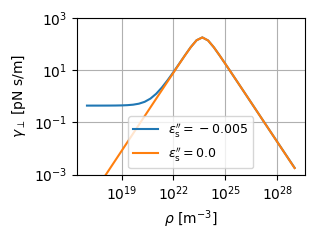

In [243]:
plt.figure(figsize=(3.25, 2.5))

sym = r'$\varepsilon_{\mathrm{s}}^{\prime\prime} = '
plt.loglog(result1['rho'].to('1/m^3').magnitude, result1['gamma'].to('pN s/m').magnitude, label=sym + '-0.005$')
plt.loglog(result2['rho'].to('1/m^3').magnitude, result2['gamma'].to('pN s/m').magnitude, label=sym + '0.0$') 

plt.legend(fontsize=9)
plt.xlabel(r'$\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('$\gamma_{\perp}$ [pN s/m]')
plt.ylim([1E-3,1e3])
plt.grid()
plt.tight_layout()

plt.savefig(THIS + '--Fig-1.png', dpi=300)
plt.savefig(THIS + '--Fig-1.pdf')

plt.show()

Looks similar to Lekkala2013 Figure 9(b), except here the dissipation is the same for the two dielectric constants at high charge density.  In Lekkala2013's Figure 9(b), in contrast, the dissipation dropped symmetically below and above the peak.

In [241]:
def labelformat(mu):
    return r'$\mu = $'  + '{:1.1e}'.format(mu) + ' m^2/(V s)'.format(mu)

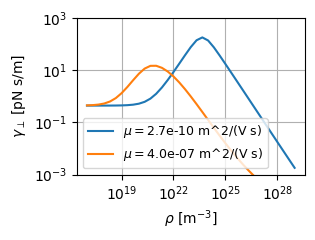

In [244]:
plt.figure(figsize=(3.25, 2.5))

sym = r'$\mu = '
plt.loglog(result1['rho'].to('1/m^3').magnitude, result1['gamma'].to('pN s/m').magnitude, label=labelformat(2.7E-10))
plt.loglog(result3['rho'].to('1/m^3').magnitude, result3['gamma'].to('pN s/m').magnitude, label=labelformat(4E-7)) 

plt.legend(fontsize=9)
plt.xlabel(r'$\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('$\gamma_{\perp}$ [pN s/m]')
plt.ylim([1E-3,1e3])
plt.grid()
plt.tight_layout()

plt.savefig(THIS + '--Fig-2.png', dpi=300)
plt.savefig(THIS + '--Fig-2.pdf')

plt.show()

I am seeing qualitatively the behavior seen in Lekkala2013's Figure 9(a).  Here, however, I am plotting the results on a log-log plot, whereas Lekkala2013's Figure 9(a) employed a log-linear plot.

It is important to note that the "sample" here is slightly different than Lekkala's.  I have computed the friction for a a doped semiconductor on a metal, whereas Lekkala in Figure 9 compute the friction for a doped semiconductor on a dielectric substrate.

Next: Go back and code Lekkala2013's Figure 9 *exactly*.